In [1]:
import kagglehub
import torch
from pandas import read_csv,concat
import matplotlib.pyplot as plt
# import numpy as np

In [2]:
# Import the Dataset from kaggle and load on a Tensor
Nist_dataset = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

chunksize = 250

# the list that contains all the dataframes
list_of_dataframes = []

for df in read_csv(Nist_dataset+"/A_Z Handwritten Data.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df)

# if you want all the dataframes together, here it is
handwritten_alphabet = concat(list_of_dataframes)



# handwritten_alphabet = read_csv(Nist_dataset+"/A_Z Handwritten Data.csv")
# print(handwritten_alphabet)
handwritten_alphabet = torch.Tensor(handwritten_alphabet.values).cuda()

In [6]:
from string import ascii_uppercase

# Crear una lista de letras del abecedario
letras = list(ascii_uppercase)  # Para mayúsculas, usa ascii_uppercase; para minúsculas, usa ascii_lowercase

# Crear el diccionario
alphabet_dictionary = {i: letras[i] for i in range(26)}

In [7]:
# Split The data on Images and Labels
# handwritten_alphabet[:,0]
handwritten_alphabet_classes = handwritten_alphabet[:,0].long()
handwritten_alphabet_images = handwritten_alphabet[:,1:].reshape((-1,28,28))

In [8]:
#Create a Dataset Class to load the Images and labels
class image_dataset(torch.utils.data.Dataset):
    def __init__(self,images:torch.Tensor,labels:torch.Tensor):
        if len(images[:]) != len(labels):
            raise IndexError("The size must be the same")
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        image = self.images[None,index]
        label = self.labels[None,index]
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [9]:
# Create and Split the dataset on Train, Validation and Test Datasets
image_dataset = image_dataset(handwritten_alphabet_images,handwritten_alphabet_classes)

train,val,test = torch.utils.data.random_split(image_dataset,[0.8,0.1,0.1])


In [ ]:
# # Show a data example
# img,lbl = train[torch.randint(len(train),size=(1,))]
# plt.imshow(img.squeeze().cpu())
# print(alphabet_dictionary[lbl.cpu().item()])

In [10]:
from torch import nn
class image_clasifier_nn(nn.Module):

    def __init__(self,image_size:int, number_of_classes:int):
        super().__init__()
        self.aplanar = nn.Flatten() # Aplana las imágenes
        self.red = nn.Sequential(
            nn.Linear(image_size*image_size,75),    #Capa de entrada
            nn.ReLU(),                              #Activación de capa entrada
            nn.Linear(75,number_of_classes),        #Capa profunda intermedia
            nn.Softmax(1)                           #Capa de salida softmax
        )



    def forward(self, x):
        x = self.aplanar(x)
        outputs = self.red(x)

        return outputs
    


In [11]:
#Create the neural Network
Letter_classifier = image_clasifier_nn(28,len(alphabet_dictionary)).cuda()

In [ ]:
# from torchsummary import summary

# summary(Letter_classifier,(28,28))

E
Predicción:  Y


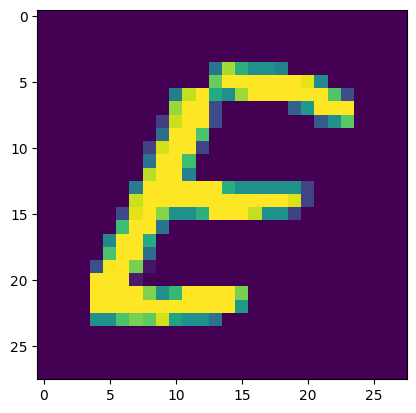

In [12]:
# Tray untrained network
img,lbl = train[torch.randint(len(train),size=(1,))]
plt.imshow(img.squeeze().cpu())

prediction = Letter_classifier(img)[0]

print(alphabet_dictionary[lbl.cpu().item()])
print("Predicción: ",alphabet_dictionary[prediction.argmax().item()])

In [13]:
batch_size = 500

train_loader = torch.utils.data.DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = torch.utils.data.DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

In [14]:
epochs = 10
learning_rate = 0.1

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Letter_classifier.parameters(), lr=learning_rate)

In [31]:
img = torch.rand((20,1,28,28)).cuda()
logits = Letter_classifier(img)
logits.shape


torch.Size([20, 26])

In [38]:
loader_prueba = torch.utils.data.DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=20
)
_,lbls = next(iter(loader_prueba))
lbls.shape

torch.Size([20, 1])

In [40]:
lbls[:,0].shape

torch.Size([20])

In [ ]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses, train_accuracy = 0,0

    for nlote,(x,y) in enumerate(loader):
        x,y = x.cuda(), y.cuda()[:,0]

        # Forward Pass
        logits = model(x)

        # Backpropagation
        loss = loss_fn(logits,y)    #Calculo de loss
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()
        train_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote: ",nlote)
            print("Loss: ",loss.item())

    train_losses /= nlotes
    train_accuracy /= train_size
    
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {(100*train_accuracy):>0.1f}% / {train_losses:>8f}")

In [ ]:
# accuracy = 0
# for n_lote in range(len(train_loader)):
#     batch = next(iter(train_loader))

#     x = batch[0].cuda()
#     y = batch[1].cuda()[:,0]

#     output_logits = Letter_classifier(x)

#     perdida = loss(output_logits,y)
#     perdida.backward()
    
#     if not n_lote%10:
#         print(f"Lote Nº {n_lote}/{len(train_loader)}: {perdida} Loss")

#     optimizer.step()
#     optimizer.zero_grad()

#     accuracy += (output_logits.argmax(1)==y).type(torch.float).sum().item()


# accuracy /= len(train_loader.dataset)
# print("Accuracy: ",100*accuracy,"%")


In [ ]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses, val_accuracy = 0,0

    with torch.no_grad():       #Calcelo el calculo del gradiente
        for x,y in loader:
            
            x,y = x.cuda(), y.cuda()[:,0]

            logits = model(x)       # Inferencia
            
            val_losses += loss_fn(logits,y.long()).item()
            val_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

    val_losses /= nlotes
    val_accuracy /= val_size

    print(f"\t\tValidación: {(100*val_accuracy):>0.1f}% / {val_losses:>8f}")



In [ ]:
for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    train_loop(train_loader,Letter_classifier,optimizer,loss)

    #Validation
    val_loop(val_loader,Letter_classifier,loss)

print("Finalizado entrenamiento del modelo!")